In [121]:
import cv2
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalMaxPooling2D, GlobalAvgPool2D, Input
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.applications.efficientnet_v2 import *

from tensorflow.image import rgb_to_grayscale
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [98]:
train_path = 'train'
labels = os.listdir(train_path)
X = []
y = []
for label in labels:
    path = os.path.join(train_path, label)
    image_names = os.listdir(path)

    for image_name in image_names:
        img = cv2.imread(os.path.join(path, image_name))
        #gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #processed = cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX)
        #img = np.concatenate([img, processed[:, :, np.newaxis]], axis=2)
        X.append(img)
        y.append(label)

X = np.array(X)
y = list(map(lambda x: int(x) - 1, y))
y = tf.one_hot(y, 3).numpy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.1)

In [100]:
test_path = 'test'
labels = os.listdir(test_path)
X_test = []
test_image_names = []
y_test = []
for label in labels:
    path = os.path.join(test_path, label)
    image_names = os.listdir(path)

    for image_name in image_names:
        img = cv2.imread(os.path.join(path, image_name))
        test_image_names.append(os.path.join(path, image_name))
        #gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #processed = cv2.normalize(gray_img, None, 0, 255, cv2.NORM_MINMAX)
        #img = np.concatenate([img, processed[:, :, np.newaxis]], axis=2)
        X_test.append(img)
        y_test.append(label)

y_test = list(map(lambda x: int(x) - 1, y_test))
y_test = tf.one_hot(y_test, 3).numpy()
X_test = np.array(X_test)

In [101]:
vgg16 = VGG16(include_top=False)
lock_cnt = int(len(vgg16.layers) * 0.3)
for layer in vgg16.layers[:lock_cnt]:
    layer.trainable = False


vgg_input = Input([None, None, 3], dtype=tf.uint8)
x = tf.cast(vgg_input, tf.float32)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = vgg16(x)
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(3, activation='softmax')(x)
my_vgg16 = tf.keras.Model(inputs=[vgg_input], outputs=[x])

my_vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
vgg_history = my_vgg16.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
26/26 [==============================] - 10s 245ms/step - loss: 10.6709 - accuracy: 0.3951 - val_loss: 1.8506 - val_accuracy: 0.3333
Epoch 2/30
26/26 [==============================] - 4s 136ms/step - loss: 1.0775 - accuracy: 0.4667 - val_loss: 1.0286 - val_accuracy: 0.3333
Epoch 3/30
26/26 [==============================] - 4s 137ms/step - loss: 1.0964 - accuracy: 0.5457 - val_loss: 0.9410 - val_accuracy: 0.9000
Epoch 4/30
26/26 [==============================] - 3s 135ms/step - loss: 0.6911 - accuracy: 0.7531 - val_loss: 0.7694 - val_accuracy: 0.7556
Epoch 5/30
26/26 [==============================] - 4s 135ms/step - loss: 0.4732 - accuracy: 0.8519 - val_loss: 0.7916 - val_accuracy: 0.8667
Epoch 6/30
26/26 [==============================] - 3s 132ms/step - loss: 0.3886 - accuracy: 0.8889 - val_loss: 0.6696 - val_accuracy: 0.9000
Epoch 7/30
26/26 [==============================] - 3s 132ms/step - loss: 0.3659 - accuracy: 0.8691 - val_loss: 0.7158 - val_accuracy: 0.8222
Epoc

In [119]:
efficient_net_b0 = EfficientNetV2B0(include_top=False)
lock_cnt = int(len(efficient_net_b0.layers) * 0.3)
for layer in efficient_net_b0.layers[:lock_cnt]:
    layer.trainable = False

my_efficient_net = Sequential([
    efficient_net_b0,
    GlobalMaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])

my_efficient_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
efficient_history = my_efficient_net.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
26/26 [==============================] - 17s 147ms/step - loss: 3.7206 - accuracy: 0.7235 - val_loss: 0.2446 - val_accuracy: 0.9222
Epoch 2/30
26/26 [==============================] - 1s 57ms/step - loss: 0.1677 - accuracy: 0.9605 - val_loss: 0.0873 - val_accuracy: 0.9889
Epoch 3/30
26/26 [==============================] - 1s 57ms/step - loss: 0.0842 - accuracy: 0.9877 - val_loss: 0.0938 - val_accuracy: 0.9889
Epoch 4/30
26/26 [==============================] - 1s 58ms/step - loss: 0.0271 - accuracy: 0.9926 - val_loss: 0.0827 - val_accuracy: 0.9667
Epoch 5/30
26/26 [==============================] - 2s 59ms/step - loss: 0.0453 - accuracy: 0.9926 - val_loss: 0.1608 - val_accuracy: 0.9667
Epoch 6/30
26/26 [==============================] - 1s 57ms/step - loss: 0.0226 - accuracy: 0.9901 - val_loss: 0.1029 - val_accuracy: 0.9667
Epoch 7/30
26/26 [==============================] - 1s 58ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1788 - val_accuracy: 0.9667
Epoch 8/30


In [113]:
my_efficient_net.save('my_efficient_net.h5')

In [114]:
resnet = ResNet50V2(include_top=False)
lock_cnt = int(len(resnet.layers) * 0.3)
for layer in resnet.layers[:lock_cnt]:
    layer.trainable = False

resnet_input = Input([None, None, 3], dtype=tf.uint8)
x = tf.cast(resnet_input, tf.float32)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = resnet(x)
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(3, activation='softmax')(x)
my_resnet = tf.keras.Model(inputs=resnet_input, outputs=x)

my_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
resnet_history = my_resnet.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
26/26 [==============================] - 13s 206ms/step - loss: 6.4228 - accuracy: 0.7210 - val_loss: 1858.2969 - val_accuracy: 0.3444
Epoch 2/30
26/26 [==============================] - 3s 97ms/step - loss: 0.3866 - accuracy: 0.9210 - val_loss: 9083.7949 - val_accuracy: 0.3444
Epoch 3/30
26/26 [==============================] - 2s 94ms/step - loss: 0.3352 - accuracy: 0.9235 - val_loss: 253.2178 - val_accuracy: 0.4444
Epoch 4/30
26/26 [==============================] - 2s 96ms/step - loss: 0.2257 - accuracy: 0.9309 - val_loss: 1843.1884 - val_accuracy: 0.3667
Epoch 5/30
26/26 [==============================] - 2s 96ms/step - loss: 0.2662 - accuracy: 0.9679 - val_loss: 949.8162 - val_accuracy: 0.4333
Epoch 6/30
26/26 [==============================] - 2s 96ms/step - loss: 0.4349 - accuracy: 0.9481 - val_loss: 34292.5898 - val_accuracy: 0.3333
Epoch 7/30
26/26 [==============================] - 2s 95ms/step - loss: 1.2438 - accuracy: 0.8272 - val_loss: 72659424.0000 - val_accu

In [120]:
miss_classified = []
for i, (img, label) in enumerate(zip(X_test, y_test)):
    expanded = tf.expand_dims(img, 0)
    pred = my_efficient_net.predict(expanded, verbose=0)
    pred_label = np.argmax(pred) + 1
    label = np.argmax(label) + 1
    if (pred_label != label):
        miss_classified.append(test_image_names[i])
        print(f'pred: {pred_label} act: {label} file: {test_image_names[i]}, index: {i}')


pred: 2 act: 1 file: test\1\MS21D0226-03A_1_012_0361_FC_U68_p1_IVS.jpg, index: 2
pred: 2 act: 1 file: test\1\MS2210131-23_1_010_0283_FC_U40_p1_IVS.jpg, index: 19


(-0.5, 249.5, 249.5, -0.5)

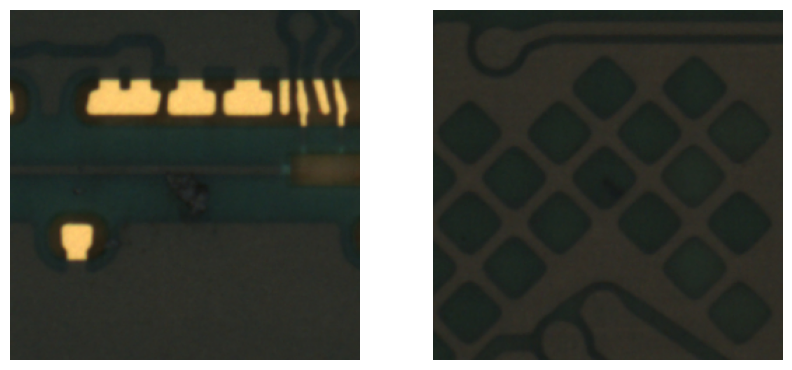

In [129]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(X_test[2].astype("uint8"), cv2.COLOR_BGR2RGB))
plt.axis("off")
ax = plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(X_test[19].astype("uint8"), cv2.COLOR_BGR2RGB))
plt.axis("off")

In [130]:
X_train_gray = rgb_to_grayscale(X_train)
X_train_gray = tf.concat([X_train_gray, X_train_gray, X_train_gray], axis=-1)

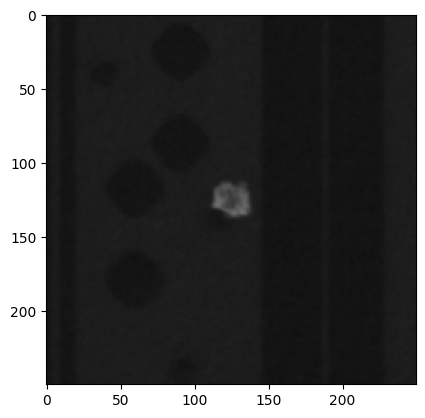

In [131]:
plt.imshow(X_train_gray[0])

In [116]:
X_train_new = np.concatenate([X_train, X_train_gray], axis=0)

In [214]:
def random_flip_and_rotate(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img),
    img = tf.image.random_hue(img, 0.5)
    return tf.squeeze(img, axis=0)

In [227]:
X_train_new = random_flip_and_rotate(X_train_new)
y_train_new = np.concatenate([y_train, y_train], axis=0)

(-0.5, 249.5, 249.5, -0.5)

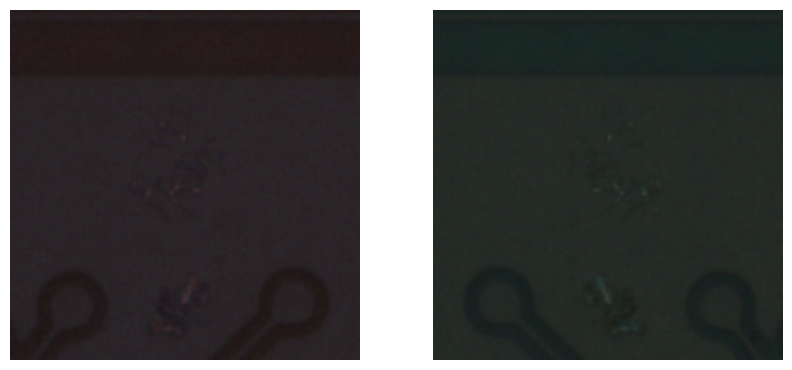

In [226]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(random_flip_and_rotate(X_train_new[7]).numpy(), cv2.COLOR_BGR2RGB))
plt.axis("off")
ax = plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(X_train_new[7].astype("uint8"), cv2.COLOR_BGR2RGB))
plt.axis("off")

In [239]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoints/checkpoint', save_best_only=True, save_weights_only=True)

In [240]:
my_model = tf.keras.models.load_model("my_efficient_net.h5")
for layer in my_model.layers:
    layer.trainable = True
history = my_model.fit(X_train_new, y_train_new, epochs=30, batch_size=16, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/30
51/51 [==============================] - 13s 116ms/step - loss: 0.1335 - accuracy: 0.9691 - val_loss: 0.0576 - val_accuracy: 0.9667
Epoch 2/30
51/51 [==============================] - 3s 57ms/step - loss: 0.1337 - accuracy: 0.9802 - val_loss: 0.1248 - val_accuracy: 0.9556
Epoch 3/30
51/51 [==============================] - 3s 55ms/step - loss: 0.1503 - accuracy: 0.9716 - val_loss: 0.1413 - val_accuracy: 0.9556
Epoch 4/30
51/51 [==============================] - 4s 70ms/step - loss: 0.0610 - accuracy: 0.9840 - val_loss: 0.0255 - val_accuracy: 0.9889
Epoch 5/30
51/51 [==============================] - 3s 56ms/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.0666 - val_accuracy: 0.9667
Epoch 6/30
51/51 [==============================] - 3s 56ms/step - loss: 0.0091 - accuracy: 0.9963 - val_loss: 0.1043 - val_accuracy: 0.9667
Epoch 7/30
51/51 [==============================] - 3s 57ms/step - loss: 0.0238 - accuracy: 0.9963 - val_loss: 0.2649 - val_accuracy: 0.9444
Epoch 8/30


In [258]:
test = tf.keras.models.load_model("my_efficient_net.h5")
test.load_weights('checkpoints/checkpoint')

In [261]:
test.evaluate(X_train, y_train)

13/13 [==============================] - 1s 74ms/step - loss: 7.5918e-04 - accuracy: 1.0000


[0.0007591781904920936, 1.0]